### Table of Contents

* [Imports](#Imports)
* [Load Data](#Load_Data)
* [Data preparation](#Data_preparation)
* [Data visualization](#Data_visualization)
    * [budget, revenue, profit](#budget_revenue_profit)
    * [genres](#genres)
    * [keywords](#keywords)
    * [original_language](#original_language)
    * [production_countries](#production_countries)
    * [production_companies](#production_companies)
    * [cast](#cast)
    * [release_year, release_month](#release_year_release_month)
    * [correlation](#correlation)
* [Recommender systems](#Recommender_systems)
    * [Weighted average](#Weighted_average)
    * [Content based](#Content_based)
    * [Content based with more features](#Content_based_with_more_features)

# **Imports** <a class="anchor" id="Imports"></a>

In [1]:
%%capture
!pip install pandas-profiling;
!pip install wordcloud
!pip install squarify
!pip install pywaffle

In [2]:
from collections import defaultdict, Counter
from functools import partial
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
from pandas_profiling import ProfileReport
from pywaffle import Waffle
import squarify
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from wordcloud import WordCloud

pd.set_option("display.max_columns", None)
%matplotlib inline

# **Load Data** <a class="anchor" id="Load_Data"></a>

In [15]:
PATH = "C:/Users/User/OneDrive - ABES/Desktop/archive2"
print(os.listdir(PATH))

['tmdb_5000_credits(2).csv', 'tmdb_5000_movies(2).csv']


In [16]:
credit = pd.read_csv(os.path.join(PATH, 'tmdb_5000_credits(2).csv'))
movie = pd.read_csv(os.path.join(PATH, 'tmdb_5000_movies(2).csv'))

In [17]:
credit.head(1)

movie_id   title                                               cast  \
0     19995  Avatar  [{"cast_id": 242, "character": "Jake Sully", "...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...

In [18]:
movie.head(1)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0      162  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  
0  Enter the World of Pandora.  Avatar           7.2       11800

In [19]:
# merge this two dataset
credit.columns = ['id','tittle','cast','crew']
movie_df = movie.merge(credit, on='id')
del movie
del credit

In [20]:
movie_df.head(1)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0      162  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  tittle  \
0  Enter the World of Pandora.  Avatar           7.2       11800  Avatar   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...

# **Data preparation** <a class="anchor" id="Data_preparation"></a>

In [21]:
# # the fastest way to get familiarize dataset and see much information
report = ProfileReport(movie_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# convert date appropriate format
movie_df["release_date"] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
del movie_df["release_date"]

In [23]:
# transform all columns which had json string into json format
# several columns has id and name
# leave only name for them beacause id is not so important in this case
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [24]:
# create director writer and producer columns 
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [25]:
# fill some missing values by most frequent one
for col in ["runtime", "release_year", "release_month"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [26]:
movie_df.head(2)

budget                                         genres  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]   
1  300000000                   [Adventure, Fantasy, Action]   

                                       homepage     id  \
0                   http://www.avatarmovie.com/  19995   
1  http://disney.go.com/disneypictures/pirates/    285   

                                            keywords original_language  \
0  [culture clash, future, space war, space colon...                en   
1  [ocean, drug abuse, exotic island, east india ...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   

                                production_companies  \
0  [Ingenious Film Partners, Twentieth Century Fo...   
1  [Walt Disney Pictures, Jerry Bruckheimer Films...   

                         production_countries     revenue  runtime  \
0  [United States of America, United Kingdom]  2787965087      162   
1                  [United States of America]   961000000      169   

     spoken_languages    status  \
0  [English, Español]  Released   
1           [English]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   

                                     tittle  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                                cast  release_year  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weave...          2009   
1  [Johnny Depp, Orlando Bloom, Keira Knightley, ...          2007   

  release_month        director         writer           producer      profit  
0      December   James Cameron  James Cameron      James Cameron  2550965087  
1           May  Gore Verbinski            NaN  Jerry Bruckheimer   661000000

# **Data visualization** <a class="anchor" id="Data_visualization"></a>

## budget, revenue, profit <a class="anchor" id="budget_revenue_profit"></a>

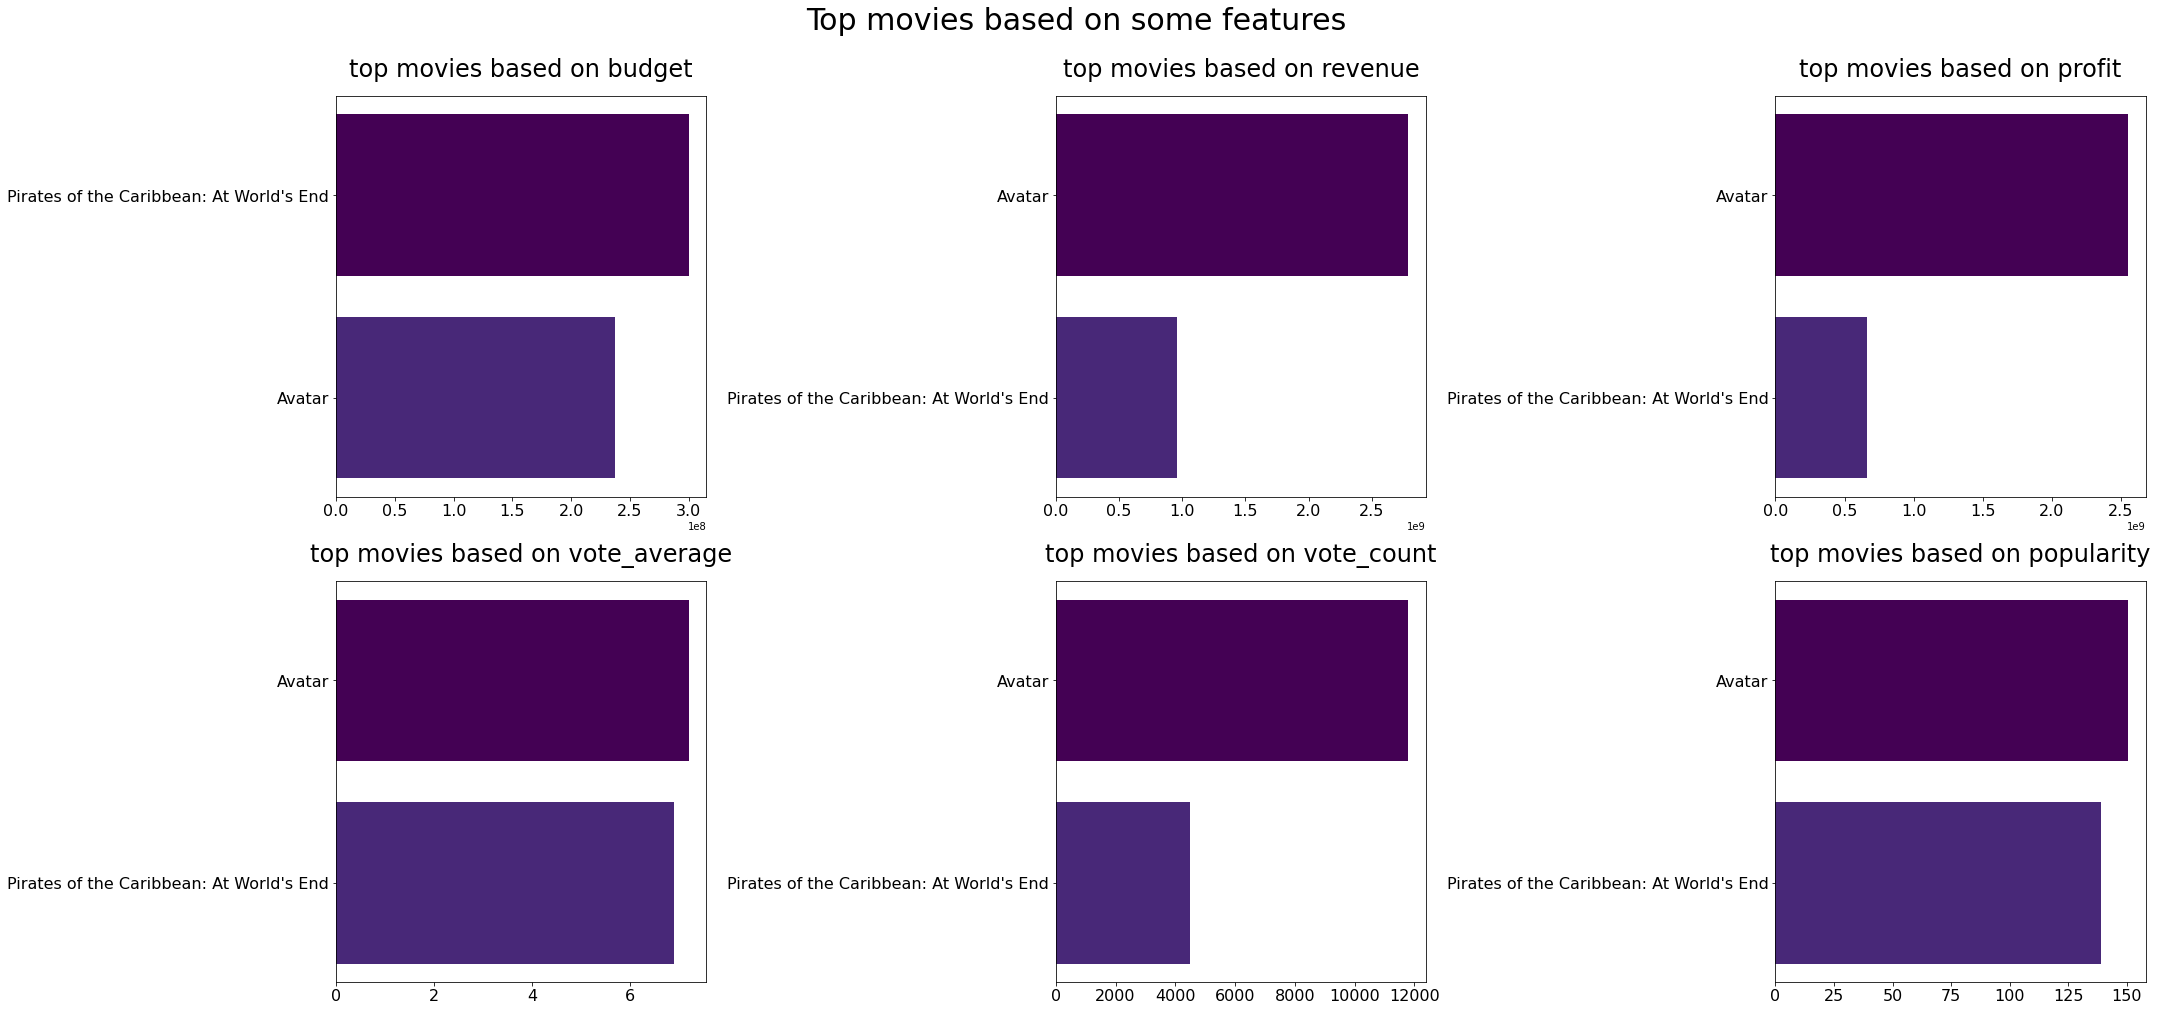

In [27]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Top movies based on some features',fontsize=30, y=1)
fig.tight_layout()

### genres <a class="anchor" id="genres"></a>

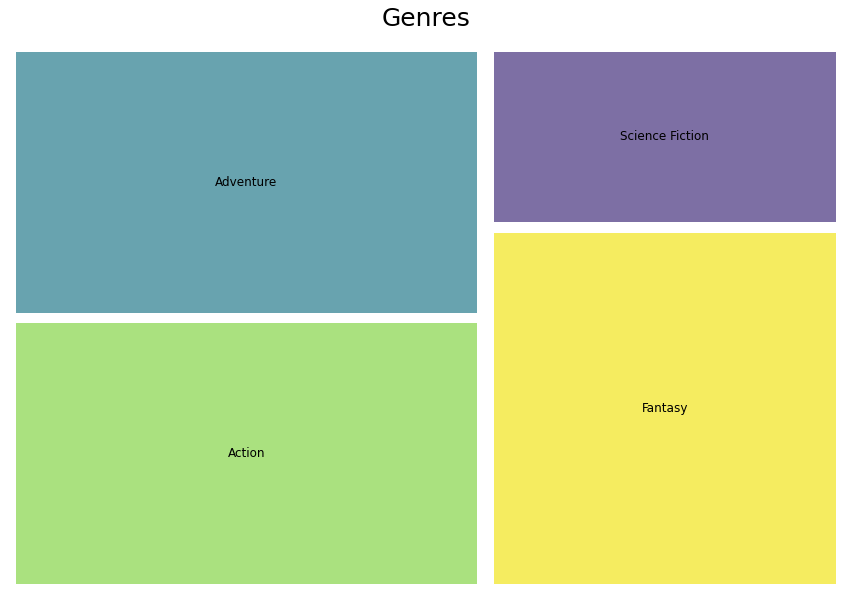

In [28]:
# plot genre frequncy with treemap 
genres_flatten = sum(movie_df["genres"].values, []) # genres are list of lists
genres_info = Counter(genres_flatten)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

### keywords <a class="anchor" id="keywords"></a>

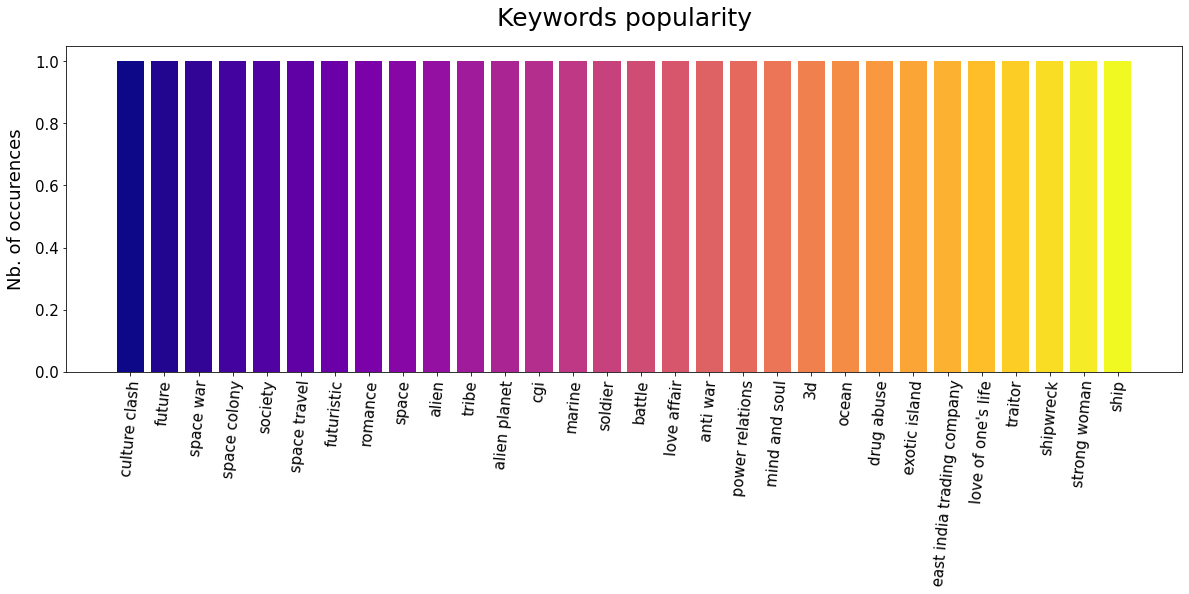

In [29]:
top_keywords_num = 30
keywords_flatten = sum(movie_df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

### original_language <a class="anchor" id="original_language"></a>

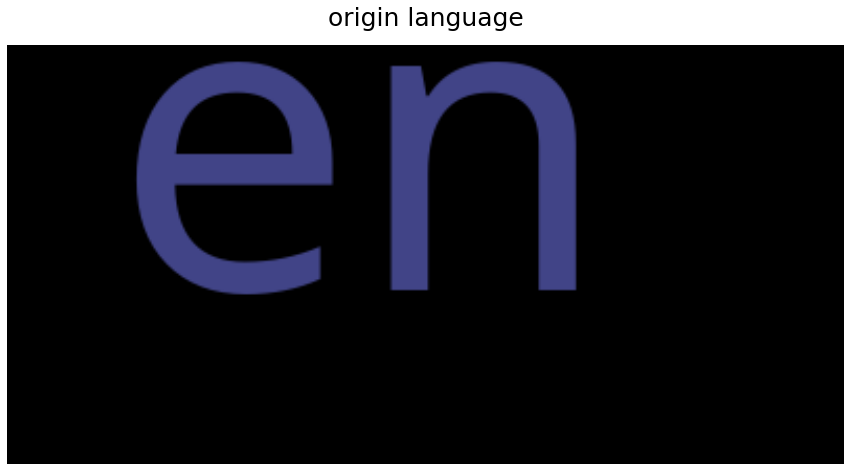

In [30]:
# plot unique cast frequency
language_info = movie_df["original_language"].value_counts()[:50]

wordcloud = WordCloud(background_color='black')
wordcloud.generate_from_frequencies(dict(language_info))

plt.figure(figsize=(15,10))
plt.title("origin language", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### production_countries <a class="anchor" id="production_countries"></a>

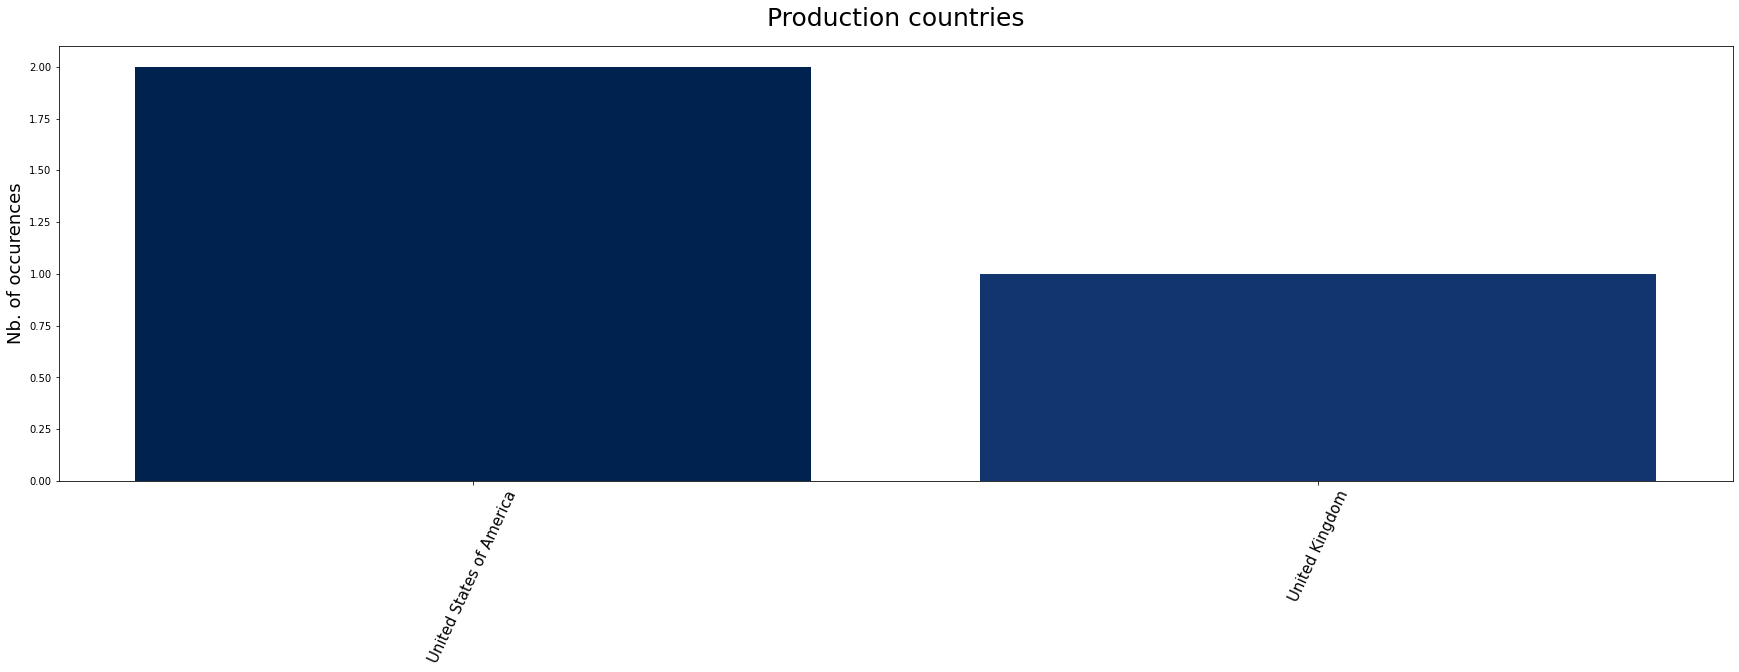

In [31]:
top_contries_num = 10
production_contries_flatten = sum(movie_df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

### production_companies <a class="anchor" id="production_companies"></a>

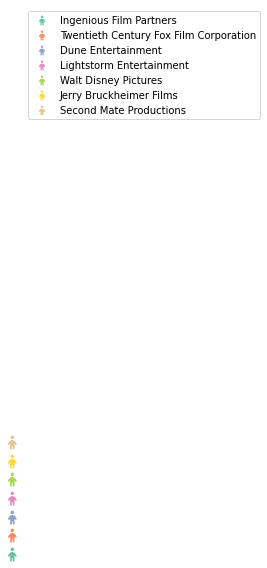

In [32]:
production_companies_flatten = sum(movie_df["production_companies"].values, []) # production_companies are list of lists
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=dict(top_production_companies), 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', icon_size=14, 
    icon_legend=True,
    figsize=(24,8)
)

### cast <a class="anchor" id="cast"></a>

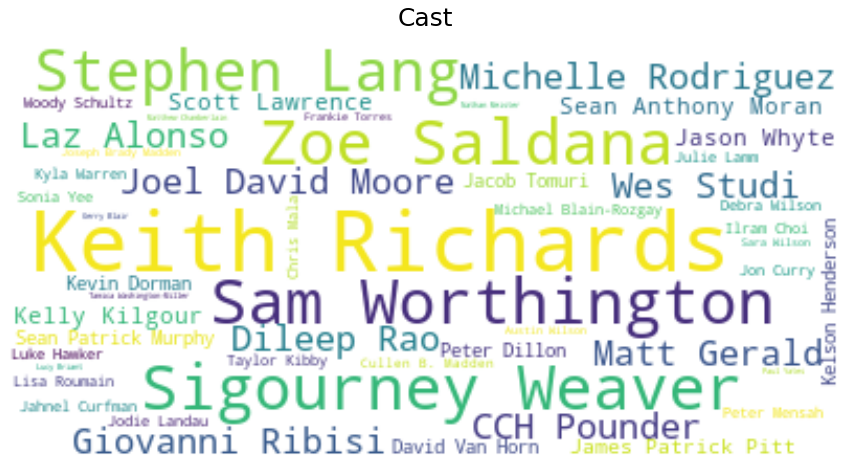

In [33]:
# plot unique cast frequency
cast_flatten = sum(movie_df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### release_year, release_month <a class="anchor" id="release_year_release_month"></a>

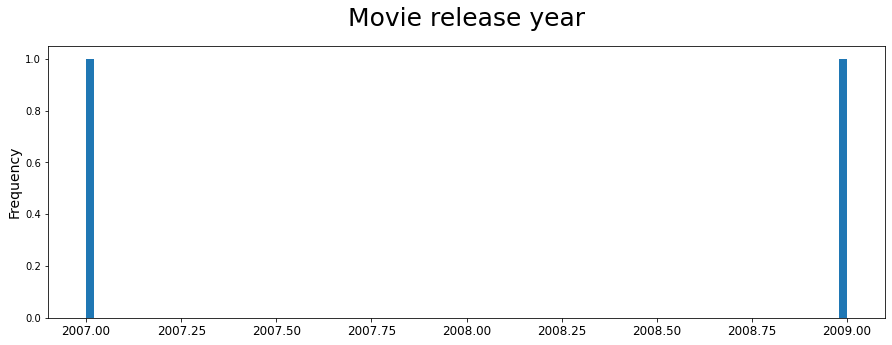

In [34]:
plt.xticks(fontsize=12)
plt.ylabel("Nb. of occurences", fontsize=14)
plt.title("Movie release year", fontsize=25, pad=20)
movie_df["release_year"].plot.hist(figsize=(15,5), bins=100);

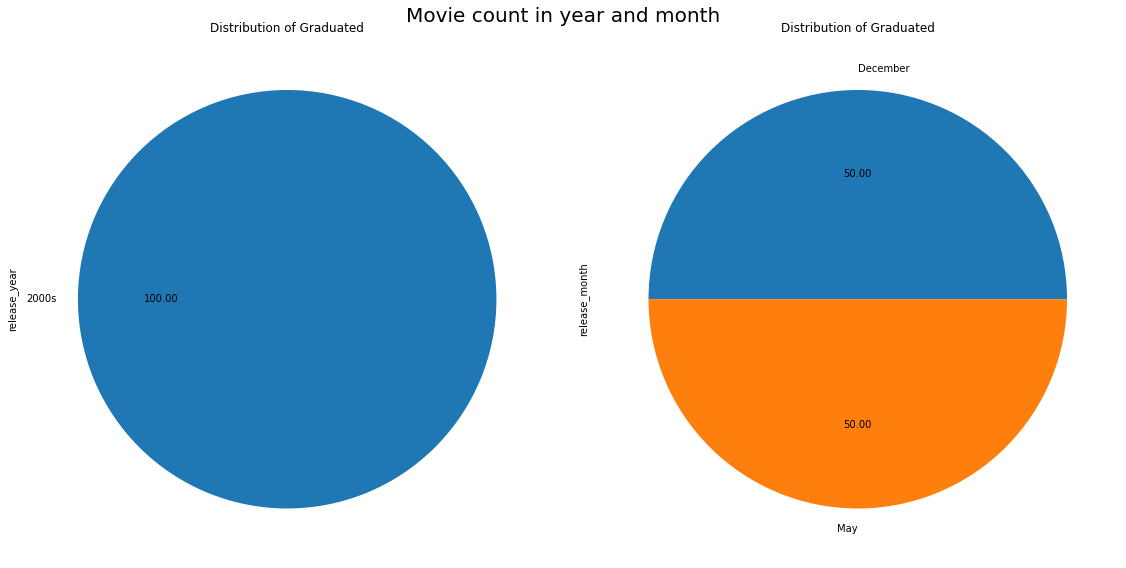

In [35]:
fig, ax  = plt.subplots(1,2,figsize = (16,8))
fig.suptitle('Movie count in year and month', fontsize=20)

movie_count_in_10th_year = movie_df["release_year"].dropna().apply(lambda x:str(int(x)//10*10)+'s').value_counts()
movie_count_in_month = movie_df["release_month"].value_counts()
    
movie_count_in_10th_year.plot.pie(title='Distribution of Graduated', ax=ax[0], autopct="%.2f")
movie_count_in_month.plot.pie(title='Distribution of Graduated', ax=ax[1], autopct="%.2f")
fig.tight_layout()

### correlation <a class="anchor" id="correlation"></a>

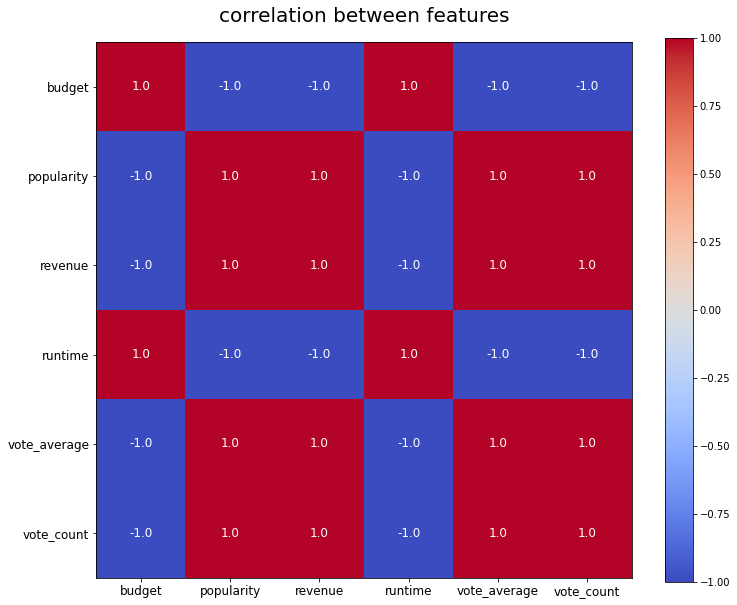

In [36]:
matrix = movie_df[["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title("correlation between features", fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

# adding values
for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j],3), ha="center", va="center", color="w", fontsize=12)
        
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar();

# **Recommender System** <a class="anchor" id="Recommender_systems"></a>

### Weighted Average <a class="anchor" id="Weighted_average"></a>

![](https://image.ibb.co/jYWZp9/wr.png)

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

- We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [37]:
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
C, m, q_movies.shape

(7.050000000000001, 11070.0, (1, 27))

In [38]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

title  vote_count  vote_average     score
0  Avatar       11800           7.2  7.127394

### Content based <a class="anchor" id="Content_based"></a>

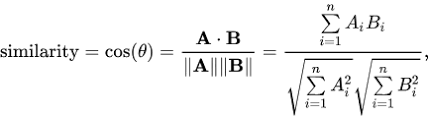

In [39]:
movie_df['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
Name: overview, dtype: object

In [40]:
movie_df['overview'] = movie_df['overview'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_df['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

tfidf_matrix.shape

(2, 29)

In [41]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [45]:
get_recommendations('The Godfather: Part II')

title  similarity
0             The Godfather    0.412329
1   The Godfather: Part III    0.259649
2  An American in Hollywood    0.121267
3       A Most Violent Year    0.111731
4                    Casino    0.110821

In [46]:
get_recommendations('The Avengers')

title  similarity
0  Avengers: Age of Ultron    0.146374
1                  Plastic    0.122791
2                  Timecop    0.110385
3       This Thing of Ours    0.107529
4    Thank You for Smoking    0.106203

In [47]:
get_recommendations('Pulp Fiction')

title  similarity
0       The Sting    0.132020
1  All or Nothing    0.114761
2   Sliding Doors    0.111997
3       Locker 13    0.111056
4     The Fighter    0.101718

### Content based with more features <a class="anchor" id="Content_based_with_more_features"></a>

In [34]:
# leave only top values for some features
# for example we dont need to take all casts
features = ['cast', 'keywords', 'genres']
top_num = 5
for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: x[:top_num] if isinstance(x, list) else [])

In [35]:
# remove spaces for some features
# because we don't need "Johnny Depp" and "Johnny Galecki" as the same
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['cast', 'keywords', 'genres', 'director', "writer", "producer", "production_companies", "production_countries"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)

In [36]:
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)

In [37]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

count_matrix.shape

(4803, 24176)

In [13]:
get_recommendations('The Godfather: Part III', cosine_sim2)

NameError: name 'get_recommendations' is not defined

In [39]:
get_recommendations('The Avengers', cosine_sim2)

title  similarity
0              Avengers: Age of Ultron    0.804030
1                           Iron Man 2    0.628828
2  Captain America: The Winter Soldier    0.611111
3           Captain America: Civil War    0.540621
4                 Thor: The Dark World    0.514496

In [40]:
get_recommendations('Pulp Fiction', cosine_sim2)

title  similarity
0  Kill Bill: Vol. 2    0.410391
1  Kill Bill: Vol. 1    0.391293
2       Jackie Brown    0.378517
3              Basic    0.300376
4     Reservoir Dogs    0.300376